# Title - Customer Churn Analysis and Prediction


## Business Problem Overview:
Customer churn directly impacts revenue and long-term growth. The objective of this project is to identify customers who are likely to churn so that proactive retention strategies can be applied. The problem is formulated as a binary classification task, where class 1 represents churned customers and class 0 represents retained customers. The primary business goal is to minimize missed churn cases, even at the cost of allowing some false positives.

# 2. Data Collection
Collecting required business data from excel file, customer dimention and fact sales

In [107]:
import pandas as pd


dc = pd.read_excel("dim_customers.xlsx")
fs = pd.read_excel("fact_sales.xlsx")
# dim_products = pd.read_excel("dim_products.xlsx")  # optional for churn


# 3. Exploratory Data Analysis (PRE)
Pre Exploratory data analysis - understand raw data shape and behavior, Data exploration and visualisation before feature engineering and before creating label, whats the story data is telling us, before taking appropriate action, remove unwanted features and impurity from the data and help in feature selection and engineering for the purpose of training our model later. 
##### Because Quality data --> Quality insights --> Quality model --> Big Business impact

### 1. Dataset Overview

In [108]:
dc.head() 


,customer_key,customer_id,customer_number,first_name,last_name,country,marital_status,gender,birthdate,create_date
0,1,11000,AW00011000,Jon,Yang,Australia,Married,Male,1971-10-06,2025-10-06
1,2,11001,AW00011001,Eugene,Huang,Australia,Single,Male,1976-05-10,2025-10-06
2,3,11002,AW00011002,Ruben,Torres,Australia,Married,Male,1971-02-09,2025-10-06
3,4,11003,AW00011003,Christy,Zhu,Australia,Single,Female,1973-08-14,2025-10-06
4,5,11004,AW00011004,Elizabeth,Johnson,Australia,Single,Female,1979-08-05,2025-10-06


In [109]:
fs.head()


,order_number,product_key,customer_key,order_date,shipping_date,due_date,sales_amount,quantity,price
0,SO54496,282,5400,2013-03-16,2013-03-23,2013-03-28,25,1,25
1,SO54496,289,5400,2013-03-16,2013-03-23,2013-03-28,5,1,5
2,SO54496,259,5400,2013-03-16,2013-03-23,2013-03-28,2,1,2
3,SO54497,174,9281,2013-03-16,2013-03-23,2013-03-28,22,1,22
4,SO54497,280,9281,2013-03-16,2013-03-23,2013-03-28,9,1,9


In [110]:
dc.shape, fs.shape


((18484, 10), (60398, 9))

In [111]:
dc.columns

Index(['customer_key', 'customer_id', 'customer_number', 'first_name',
       'last_name', 'country', 'marital_status', 'gender', 'birthdate',
       'create_date'],
      dtype='object')

In [112]:
fs.columns

Index(['order_number', 'product_key', 'customer_key', 'order_date',
       'shipping_date', 'due_date', 'sales_amount', 'quantity', 'price'],
      dtype='object')

### 2. Missing Value Analysis

In [113]:
fs.isnull().sum()

order_number      0
product_key       0
customer_key      0
order_date       19
shipping_date     0
due_date          0
sales_amount      0
quantity          0
price             0
dtype: int64

##### Found :  19 "order_date" null values, will manage in data cleaning phase

In [114]:
dc.isnull().sum()

customer_key         0
customer_id          0
customer_number      0
first_name           0
last_name            0
country            337
marital_status       0
gender              15
birthdate           17
create_date          0
dtype: int64

##### Found :  337 "country" , 15 "genders" and 17 "birthdate" null values, will manage in data cleaning phase

###  3. Age Distribution

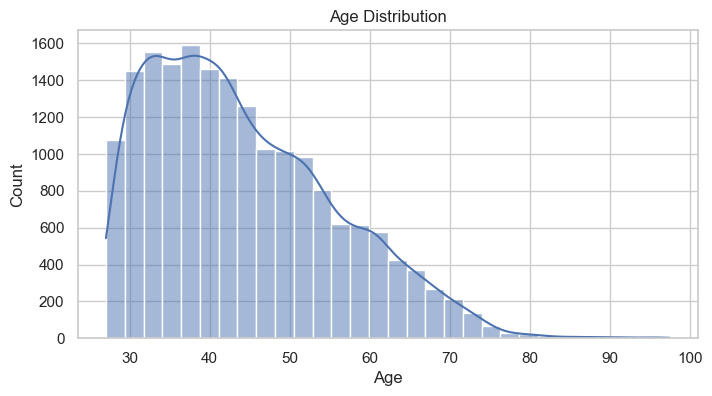

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

dc['birthdate'] = pd.to_datetime(dc['birthdate'], errors='coerce')
cutoff = pd.to_datetime("2013-06-30")
dc['age'] = (cutoff - dc['birthdate']).dt.days / 365
dc['age'] = dc['age'].fillna(dc['age'].median())


plt.figure(figsize=(8,4))
sns.histplot(dc['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()


### Visual insight : 
Most customers fall in the 30–45 age range,
The distribution is right-skewed,
Very few customers are above 65

### Business insight:
The core customer base is working-age adults with stable purchasing power,
Retention strategies should primarily target the 30–50 segment, as it represents the highest revenue opportunity,
Older age groups form a smaller share and are less impactful for churn reduction efforts,
Age alone is not a churn driver, but it helps segment customers for personalized retention campaigns,

### Why this matters (Pre-EDA purpose)
Confirms age is usable and meaningful or not
Helps decide whether to keep age for modeling and segmentation


### 4. Gender Distribution

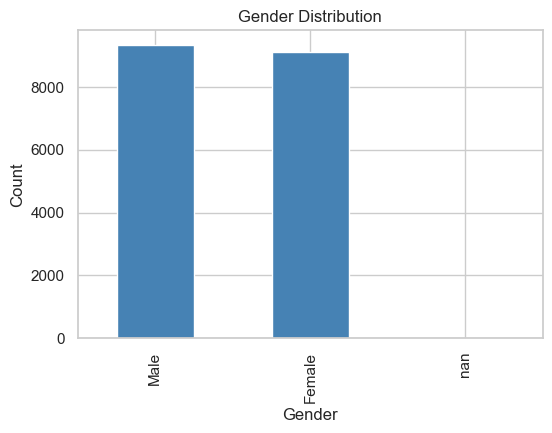

In [116]:
plt.figure(figsize=(6,4))
dc['gender'].value_counts(dropna=False).plot(kind='bar',color='steelblue')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

### Visual insight :

Male and female customers are almost evenly distributed,
Missing gender values exist but are relatively small

### Business insight :

The product appeals broadly across genders,
Gender alone is unlikely to strongly influence churn behavior,
Gender can be useful for segmentation and reporting, but not as a core predictive feature

### Why this matters (Pre-EDA purpose)

Indicates gender is balanced and non-biased
Supports the decision to treat gender as optional in modeling

### 5. Country Distribution

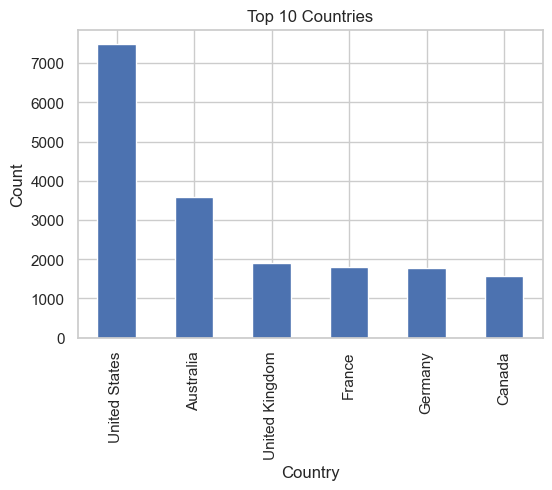

In [117]:
plt.figure(figsize=(6,4))
dc['country'].value_counts().plot(kind='bar')
plt.title("Top 10 Countries")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()


### Visual insight:
Majority of customers are from the United States
Australia is the second largest market
Other countries contribute significantly smaller shares

### Business insight:
The business is heavily dependent on the US market
Country distribution suggests market concentration rather than churn behavior
Geographic features may add noise without strong predictive value

### Why this matters (Pre-EDA purpose)

Helps decide whether to exclude country from the ML model
Supports keeping country for dashboards, not prediction

### 6. Monthly Orders Over Time

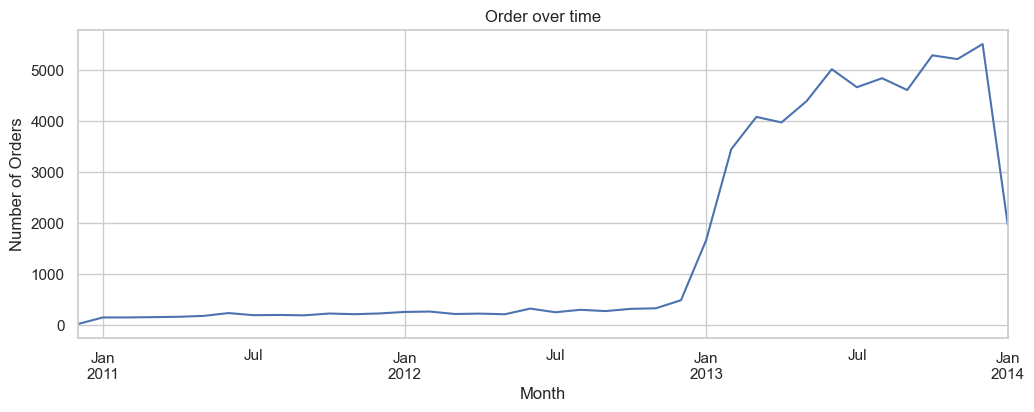

In [118]:
fs['order_date'] = pd.to_datetime(fs['order_date'])

monthly_orders = fs.groupby(fs['order_date'].dt.to_period('M')).size()

plt.figure(figsize=(12,4))
monthly_orders.plot()
plt.title("Order over time")
plt.xlabel("Month")
plt.ylabel("Number of Orders")
plt.show()

### Visual insight:

Stable order volume from 2011 to 2012,
Sharp growth starting in early 2013,
Sudden drop near early 2014 due to data cutoff

### Business insight:

The business experienced rapid growth during 2013,
Time-based trends confirm that churn must be defined carefully to avoid data leakage,
Reinforces the need for a cutoff-based churn definition

### Why this matters (Pre-EDA purpose)

Validates temporal structure of the data
Confirms feasibility of time-based churn modeling

### 7.Sales amount Distribution

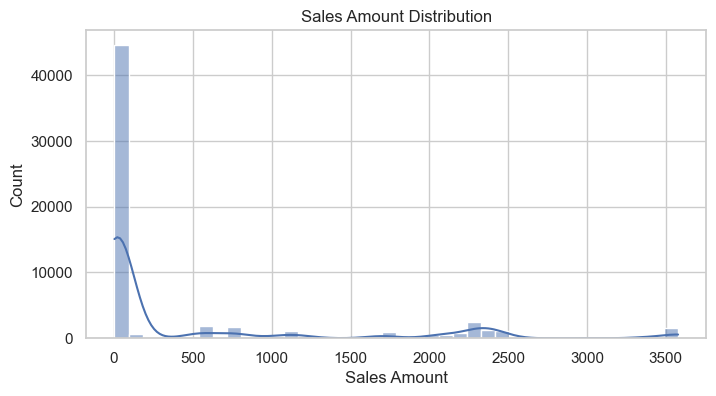

In [119]:
plt.figure(figsize=(8,4))
sns.histplot(fs['sales_amount'], bins=40, kde=True)
plt.title("Sales Amount Distribution")
plt.xlabel("Sales Amount")
plt.show()

### Visual insight

Sales amounts are highly right-skewed,
Most transactions are low-value,
A small number of high-value purchases exist.

### Business insight
Revenue is driven by a small subset of high-value transactions,
Average sales metrics alone may hide important customer behavior,
Aggregated spend features are more meaningful than individual transaction values.

### Why this matters (Pre-EDA purpose)
Validates temporal structure of the data
Confirms feasibility of time-based churn modeling

### 8. Quantity Distribution

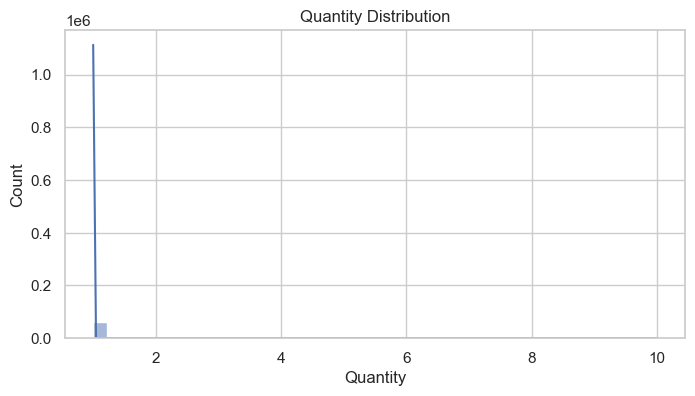

In [120]:
plt.figure(figsize=(8,4))
sns.histplot(fs['quantity'], bins=40, kde=True)
plt.title("Quantity Distribution")
plt.xlabel("Quantity")
plt.show()


### Visual insight

Most transactions involve small quantities,
Very few transactions include large quantities,

### Business insight
Customers typically purchase limited items per order,
Quantity alone is not a strong signal, but useful when combined with order frequency

### Why this matters (Pre-EDA purpose)
Supports combining quantity with frequency-based features
Confirms no extreme data quality issue

In [121]:
(fs['quantity']>1).sum()

11

### 9. Orders per Customer (Raw Frequency)

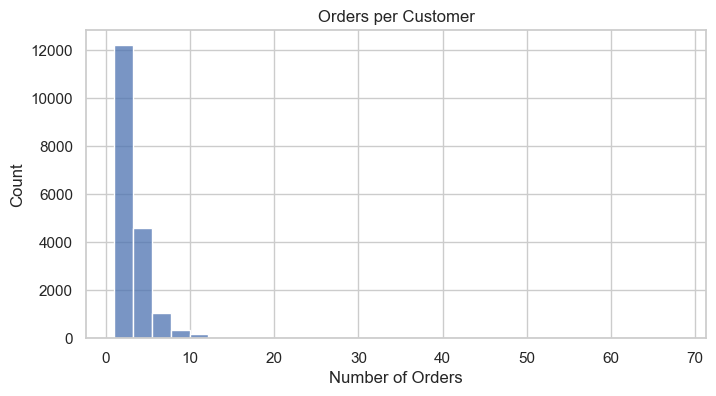

In [122]:
order_per_customer = fs.groupby("customer_key")['order_number'].count()

plt.figure(figsize=(8,4))
sns.histplot(order_per_customer, bins = 30 )
plt.title("Orders per Customer")
plt.xlabel("Number of Orders")
plt.show()

### Visual insight

Majority of customers place only a few orders,
A small group of customers places many orders,
Distribution is heavily right-skewed

### Business insight

Customer base consists largely of low-frequency buyers,
A small loyal segment contributes disproportionately to engagement,
Frequency is likely a strong behavioral indicator for churn modeling

### Why this matters (Pre-EDA purpose)

Supports combining quantity with frequency-based features
Confirms no extreme data quality issue

# Pre-EDA Summary:
This initial exploratory analysis was conducted to understand raw data distributions, identify potential data quality issues, and guide subsequent data cleaning and feature engineering steps. No churn-specific conclusions are drawn at this stage. Insights from this section informed decisions such as feature inclusion, aggregation strategies, and the exclusion of weak predictors.

# DATA CLEANING

### 1. Convert dates correctly

In [123]:
fs['order_date'] = pd.to_datetime(fs['order_date'], errors='coerce')
dc['birthdate'] = pd.to_datetime(dc['birthdate'], errors='coerce')

### 2. Remove invalid sales rows

In [124]:
# Drop missing order dates
fs = fs.dropna(subset=['order_date'])

# Drop missing order dates
fs = fs.dropna(subset=['customer_key'])

### 3. Handle missing demographic information

In [125]:
# Fill missing gender and country
dc['gender'] = dc['gender'].fillna("Unknown")
dc['country'] = dc['country'].fillna("Unknown")

### 4. Create age and fix missing birthdates

In [126]:
dc['age']= ((pd.to_datetime("2013-06-30") - dc['birthdate']).dt.days / 365)
dc['age'] = dc['age'].fillna(dc['age'].median())
dc.drop('birthdate', axis=1, inplace=True)

###  5. Remove duplicate customer rows (if any)

In [127]:
dc = dc.drop_duplicates(subset=['customer_key'])

### 6. Check cleaned data

In [128]:
print("Missing values in dc after cleaning:")
print(dc.isnull().sum())

dc.head()

Missing values in dc after cleaning:
customer_key       0
customer_id        0
customer_number    0
first_name         0
last_name          0
country            0
marital_status     0
gender             0
create_date        0
age                0
dtype: int64


,customer_key,customer_id,customer_number,first_name,last_name,country,marital_status,gender,create_date,age
0,1,11000,AW00011000,Jon,Yang,Australia,Married,Male,2025-10-06,41.761644
1,2,11001,AW00011001,Eugene,Huang,Australia,Single,Male,2025-10-06,37.164384
2,3,11002,AW00011002,Ruben,Torres,Australia,Married,Male,2025-10-06,42.416438
3,4,11003,AW00011003,Christy,Zhu,Australia,Single,Female,2025-10-06,39.904110
4,5,11004,AW00011004,Elizabeth,Johnson,Australia,Single,Female,2025-10-06,33.926027


In [129]:
print("\nMissing values in fs after cleaning:")
print(fs.isnull().sum())

fs.head()



Missing values in fs after cleaning:
order_number     0
product_key      0
customer_key     0
order_date       0
shipping_date    0
due_date         0
sales_amount     0
quantity         0
price            0
dtype: int64


,order_number,product_key,customer_key,order_date,shipping_date,due_date,sales_amount,quantity,price
0,SO54496,282,5400,2013-03-16,2013-03-23,2013-03-28,25,1,25
1,SO54496,289,5400,2013-03-16,2013-03-23,2013-03-28,5,1,5
2,SO54496,259,5400,2013-03-16,2013-03-23,2013-03-28,2,1,2
3,SO54497,174,9281,2013-03-16,2013-03-23,2013-03-28,22,1,22
4,SO54497,280,9281,2013-03-16,2013-03-23,2013-03-28,9,1,9


# 4. Feature Engineering
Raw transactional data does not directly describe customer behavior in a way a churn model can learn from. Individual orders need to be transformed into customer-level behavioral signals that summarize how recently, how often, and how much a customer interacts with the business.

In this step, historical transactions are split into two time windows. Transactions before the cutoff date are used to create features, while transactions after the cutoff date are reserved only for churn labeling. This separation ensures that no future information leaks into the model.

The goal of feature engineering here is to represent each customer’s engagement pattern as it existed at the time of prediction, similar to how a real business would assess customer risk.

In [130]:
import pandas as pd

# Ensure date column is datetime
fs['order_date'] = pd.to_datetime(fs['order_date'], errors='coerce')

# Cutoff and future windows
cutoff = pd.to_datetime("2013-06-30")
future_start = pd.to_datetime("2013-07-01")
future_end = pd.to_datetime("2014-01-28")

# Past transactions (for feature engineering)
fs_past = fs[fs['order_date'] <= cutoff].copy()

# Future transactions (for churn labeling)
fs_future = fs[(fs['order_date'] >= future_start) &
               (fs['order_date'] <= future_end)].copy()


In [131]:
fs_future.head()

,order_number,product_key,customer_key,order_date,shipping_date,due_date,sales_amount,quantity,price
15470,SO61313,138,428,2013-07-01,2013-07-08,2013-07-13,1701,1,1701
15471,SO61313,166,428,2013-07-01,2013-07-08,2013-07-13,9,1,9
15472,SO61313,245,428,2013-07-01,2013-07-08,2013-07-13,35,1,35
15473,SO61314,260,212,2013-07-01,2013-07-08,2013-07-13,120,1,120
15474,SO61315,286,4147,2013-07-01,2013-07-08,2013-07-13,25,1,25


### 1. Create Core Behavioral Features :
Customer-level features are created by aggregating past transaction history. These features capture three key dimensions of customer behavior:

Frequency: how often a customer places orders

Monetary value: how much the customer spends

Timing: how recent and how long the customer has been active

Total orders, total sales, and total quantity summarize engagement and value.
First and last order dates provide the foundation for time-based features such as recency and lifespan.

These aggregated metrics reduce noise from individual transactions and create a stable behavioral profile for each customer.

In [132]:
features = fs_past.groupby('customer_key').agg(
    total_orders=('order_number', 'count'),
    total_sales=('sales_amount', 'sum'),
    total_quantity=('quantity', 'sum'),
    last_order_date=('order_date', 'max'),
    first_order_date=('order_date', 'min')
).reset_index()


### 2. Create Derived Features :
Additional features are derived to better reflect customer behavior trends:

Recency measures how long it has been since the customer’s last purchase. Customers who stop purchasing for long periods are more likely to churn.

Lifespan captures how long a customer has been active with the business. Longer relationships often indicate higher loyalty.

Average order value reflects purchase quality rather than volume.

Average monthly spend normalizes spending by customer lifespan, making customers with different tenures comparable.

These derived features help the model distinguish between temporary inactivity and genuine disengagement.

In [133]:
# Recency: days since last purchase
features['recency'] = (cutoff - features['last_order_date']).dt.days

# Lifespan in months
features['lifespan'] = (cutoff - features['first_order_date']).dt.days / 30

# Avoid division errors
features['avg_order_value'] = features['total_sales'] / features['total_orders']
features['avg_monthly_spend'] = features['total_sales'] / (features['lifespan'] + 1)


### 3. Add Customer Attributes:
Basic customer attributes such as age, gender, and country are added to the dataset to complement behavioral features. These attributes are not expected to be strong churn drivers on their own, but they provide useful context for segmentation and analysis.

Behavioral features remain the primary predictors, while demographic attributes act as supporting signals.

In [134]:
dc_small = dc[['customer_key', 'age', 'gender', 'country']]

### 4. Merge Features with Customer Info

In [135]:
df = features.merge(dc_small, on='customer_key', how='left')
df.head()

,customer_key,total_orders,total_sales,total_quantity,last_order_date,first_order_date,recency,lifespan,avg_order_value,avg_monthly_spend,age,gender,country
0,1,8,8249,8,2013-05-03,2011-01-19,58,29.766667,1031.125000,268.114843,41.761644,Male,Australia
1,2,7,5795,7,2013-01-16,2011-01-15,165,29.900000,827.857143,187.540453,37.164384,Male,Australia
2,3,4,8114,4,2013-02-23,2011-01-07,127,30.166667,2028.500000,260.342246,42.416438,Male,Australia
3,4,9,8139,9,2013-05-10,2010-12-29,51,30.466667,904.333333,258.654661,39.904110,Female,Australia
4,5,6,8196,6,2013-05-01,2011-01-23,60,29.633333,1366.000000,267.551687,33.926027,Female,Australia


### 5. Churn Label Creation :
Churn Label Creation

Churn is defined using a future observation window. A customer is labeled as churned if they make no purchases during the future period following the cutoff date.

This time-based definition mirrors how churn is observed in real business settings and ensures that the model learns from past behavior only. By separating feature creation and churn labeling across time, the dataset avoids data leakage and produces realistic model performance.

In [136]:
# Identify customers who made purchases in the future window
active_customers = fs_future['customer_key'].unique()

# churn = 1 if not active in future window
df['churn'] = (~df['customer_key'].isin(active_customers)).astype(int)


In [137]:
df['churn'].value_counts()

churn
1    7142
0    4272
Name: count, dtype: int64

# Exploratory Data Analysis (POST)

### 1.Churn Distribution

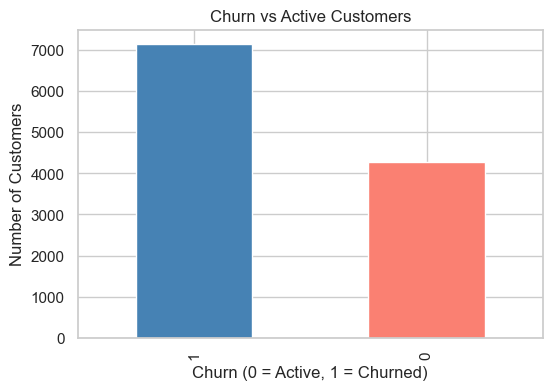

In [138]:
plt.figure(figsize=(6,4))
df['churn'].value_counts().plot(kind='bar', color=['steelblue','salmon'])
plt.title("Churn vs Active Customers")
plt.xlabel("Churn (0 = Active, 1 = Churned)")
plt.ylabel("Number of Customers")
plt.show()


##### Visual insight

The dataset contains more churned customers than active customers,
Class distribution is moderately imbalanced

##### Business insight

Customer attrition is a significant business issue, not a rare event,
Retention strategies can create meaningful impact because a large portion of customers are at risk,
Class imbalance justifies using recall-focused metrics and class-weighted models

#### Why this matters

Confirms churn prediction is a valid and necessary problem
Supports prioritizing churn recall over raw accuracy

### 2. Recency vs Churn

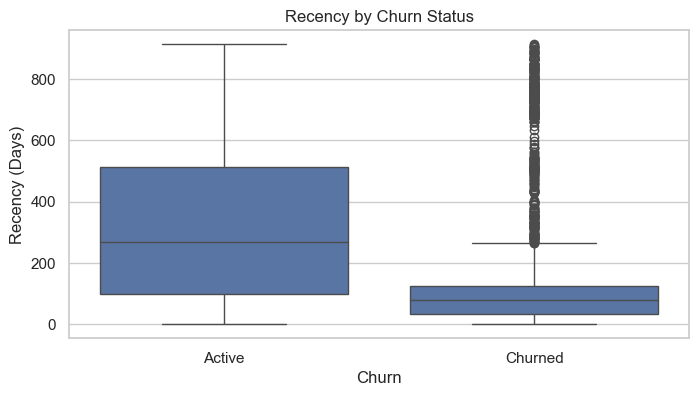

In [139]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='churn', y='recency')
plt.title("Recency by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Recency (Days)")
plt.xticks([0,1], ["Active", "Churned"])
plt.show()


##### Visual insight

Churned customers show lower recency values compared to active customers,
Active customers have a wider spread of recency values,
Significant overlap exists, indicating recency alone is not sufficient

##### Business insight

Churn is associated with a change in purchasing behavior rather than a single inactivity threshold
Some customers churn shortly after their last purchase, while others remain active despite longer gaps
Recency is a strong signal but must be interpreted alongside other behavioral features

##### Why this matters

Justifies using recency as a core churn feature
Reinforces the need for multi-feature modeling rather than rule-based churn logic

### 3. Total Orders vs Churn

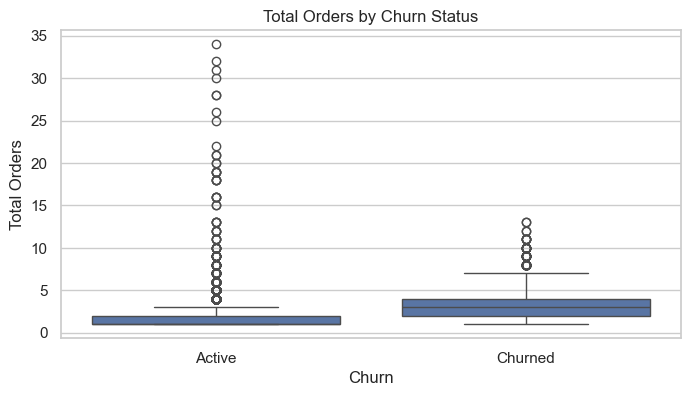

In [140]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='churn', y='total_orders')
plt.title("Total Orders by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Total Orders")
plt.xticks([0,1], ["Active", "Churned"])
plt.show()


##### Visual insight

Churned customers have a higher median number of total orders than active customers,
Active customers show a long tail with a small group of very frequent buyers,
Strong overlap exists between the two groups,

##### Business insight:

Churn is not driven by low purchase frequency alone,
Customers with multiple past orders can still churn,
Past engagement does not guarantee future retention

##### Why this matters:

Retention strategies should not focus only on low-frequency customers,
Even previously loyal customers require monitoring,
Frequency must be combined with recency and spend to assess risk.

### 4.Total Sales vs Churn

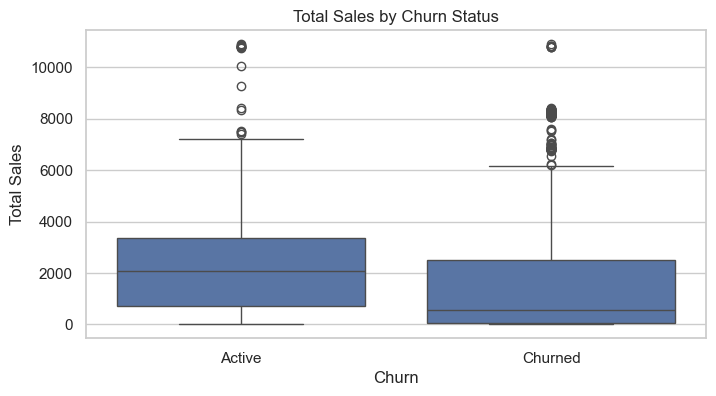

In [141]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='churn', y='total_sales')
plt.title("Total Sales by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Total Sales")
plt.xticks([0,1], ["Active", "Churned"])
plt.show()


##### Visual insight:

Active customers have higher median total sales,
Churned customers include several high-spending outliers,
Wide variance exists in both groups

##### Business insight:
Churn is not limited to low-value customers
High-value customers can and do churn
Losing a small number of high-spend customers can cause large revenue loss

##### Why this matters:
Retention strategies should prioritize value + risk, not just value
Justifies ranking customers by churn probability rather than total spend

### 5. Average Monthly Spend vs Churn

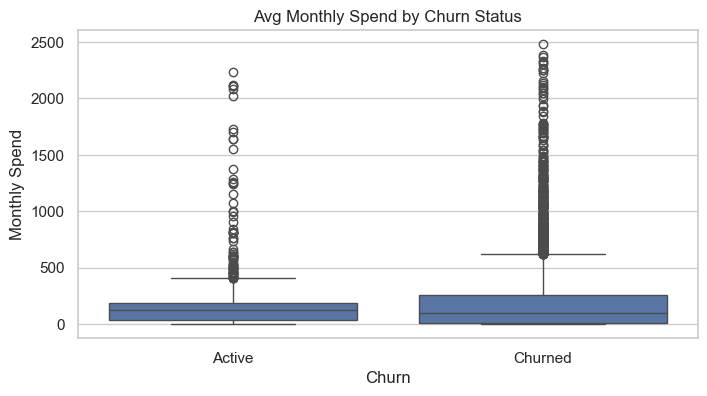

In [142]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='churn', y='avg_monthly_spend')
plt.title("Avg Monthly Spend by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Monthly Spend")
plt.xticks([0,1], ["Active", "Churned"])
plt.show()

##### Visual insight

Active customers show a slightly higher median average monthly spend
Churned customers exhibit wide variability, including several high-spending outliers
Strong overlap exists between churned and active customers

##### Business insight

Higher historical spending does not guarantee customer retention
Some customers churn despite having strong spending patterns in the past
Decline or change in spending behavior is more important than absolute spend

##### Why this matters

Retention strategies should not rely only on historical spend levels
High-value customers still require monitoring and proactive engagement
Average monthly spend is most useful when combined with recency and frequency signals

### 6.lifespan vs churn

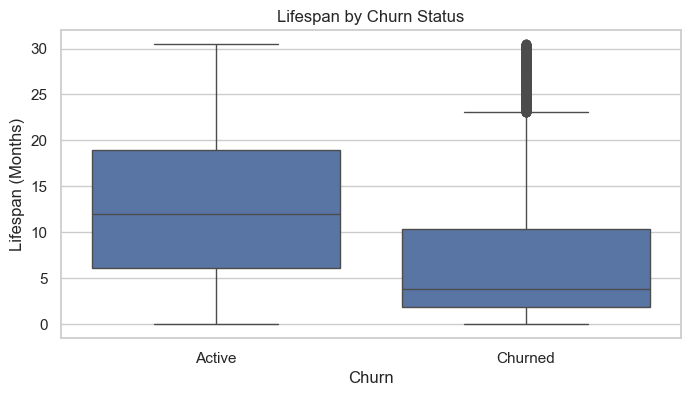

In [143]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x='churn', y='lifespan')
plt.title("Lifespan by Churn Status")
plt.xlabel("Churn")
plt.ylabel("Lifespan (Months)")
plt.xticks([0,1], ["Active", "Churned"])
plt.show()

##### Visual insight:
Active customers generally have longer lifespans
Churned customers tend to have shorter customer lifetimes
Some churned customers still show relatively long lifespans

##### Business insight:
Longer customer relationships are associated with higher retention
Newer customers are more vulnerable to churn
However, long-tenure customers can still disengage

##### Why this matters:
Early-stage customers should receive onboarding and engagement support
Lifespan is a useful loyalty indicator but not a guarantee of retention
Retention efforts should span both new and long-term customers

### 7.Correlation Heatmap

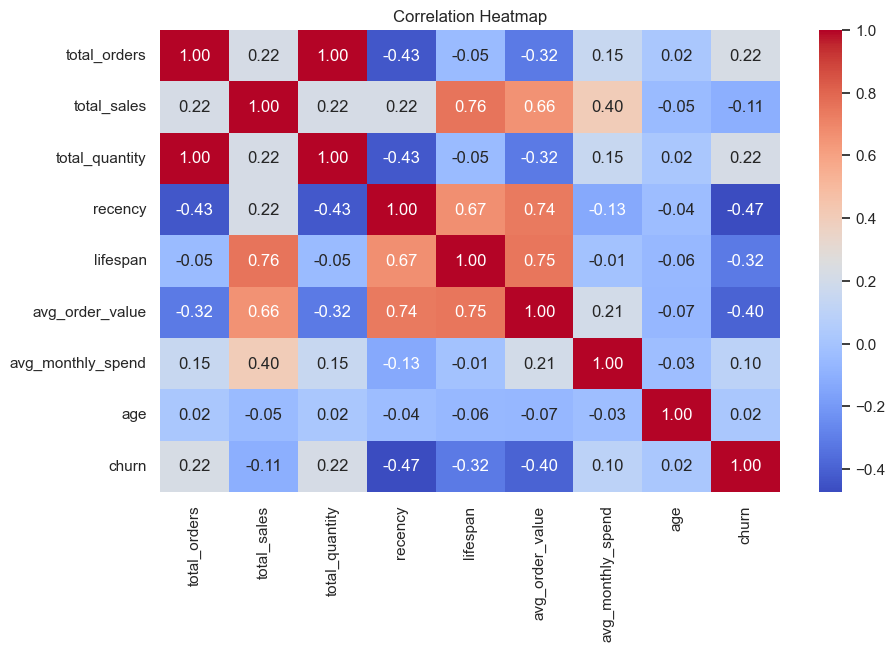

In [144]:
plt.figure(figsize=(10,6))
corr = df[['total_orders','total_sales','total_quantity','recency',
           'lifespan','avg_order_value','avg_monthly_spend','age','churn']].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


##### Visual insight:
Strong correlations exist among behavioral features
total_orders and total_quantity
total_sales with avg_order_value and lifespan
Churn shows strongest negative correlation with recency, lifespan, and avg_order_value
Age has near-zero correlation with churn

##### Business insight
Churn is primarily driven by behavioral factors rather than demographics
Time-based and value-based signals matter more than customer attributes
Correlated behavioral features reflect different views of customer engagement

##### Why this matters
Confirms recency as a key churn driver
Supports deprioritizing demographic features like age
Justifies using tree-based models that handle correlated features well

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11414 entries, 0 to 11413
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_key       11414 non-null  int64         
 1   total_orders       11414 non-null  int64         
 2   total_sales        11414 non-null  int64         
 3   total_quantity     11414 non-null  int64         
 4   last_order_date    11414 non-null  datetime64[ns]
 5   first_order_date   11414 non-null  datetime64[ns]
 6   recency            11414 non-null  int64         
 7   lifespan           11414 non-null  float64       
 8   avg_order_value    11414 non-null  float64       
 9   avg_monthly_spend  11414 non-null  float64       
 10  age                11414 non-null  float64       
 11  gender             11414 non-null  object        
 12  country            11414 non-null  object        
 13  churn              11414 non-null  int32         
dtypes: dat

# Feature Selection:

Feature selection focuses on retaining variables that meaningfully explain customer churn while removing identifiers, redundant timestamps, and low-signal attributes. The final feature set prioritizes behavioral patterns over static or descriptive information.

#### Dropped features

customer_key: identifier with no predictive value
last_order_date, first_order_date: replaced by recency and lifespan
country, gender: low predictive contribution and added noise

#### Selected features

recency, lifespan: time-based engagement signals
total_orders, total_quantity: purchase frequency and volume
total_sales, avg_order_value, avg_monthly_spend: monetary behavior
age: supporting demographic context
churn: target variable

This selection reduces noise, prevents leakage, and keeps the model focused on customer behavior, which is the primary driver of churn.

In [146]:
# Drop unnecessary columns
df_model = df.drop([
    'customer_key',        # identifier
    'last_order_date',     # raw date, we use recency instead
    'first_order_date',    # raw date, lifespan already computed
    'country',
    'gender'# low relevance, high noise
], axis=1)

df_model.head()


,total_orders,total_sales,total_quantity,recency,lifespan,avg_order_value,avg_monthly_spend,age,churn
0,8,8249,8,58,29.766667,1031.125000,268.114843,41.761644,1
1,7,5795,7,165,29.900000,827.857143,187.540453,37.164384,0
2,4,8114,4,127,30.166667,2028.500000,260.342246,42.416438,1
3,9,8139,9,51,30.466667,904.333333,258.654661,39.904110,1
4,6,8196,6,60,29.633333,1366.000000,267.551687,33.926027,1


In [147]:
df_model.shape

(11414, 9)

# Train Test Split

Train–Test Split Strategy
The dataset was split into training and test sets to evaluate the model on unseen data. This helps prevent data leakage and ensures that model performance reflects real-world behavior. The split ratio was chosen to balance learning capacity and evaluation reliability.

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Define X and y
X = df_model.drop('churn', axis=1)
y = df_model['churn']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


# Model Training 
A Random Forest classifier is used to model customer churn. This algorithm is well-suited for this problem because it captures non-linear relationships, handles feature interactions effectively, and performs well on tabular business data.

##### Why Random Forest

Handles mixed feature scales without strict assumptions
Robust to outliers and correlated features
Provides feature importance for interpretability

##### Training setup

n_estimators = 300 to ensure stable and reliable predictions
class_weight = 'balanced' to address churn class imbalance
random_state = 42 for reproducibility

The model is trained on the training split to learn behavioral patterns that distinguish churned customers from active ones.

In [149]:

# Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight='balanced',
    max_depth=None,
    random_state=42
)

# Train the model
rf.fit(X_train, y_train)

print("Training completed.")


Training completed.


# MODEL EVALUATION

In [150]:
# Predictions
y_pred = rf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1282
           1       0.84      0.90      0.87      2143

    accuracy                           0.83      3425
   macro avg       0.82      0.80      0.81      3425
weighted avg       0.83      0.83      0.83      3425

[[ 909  373]
 [ 215 1928]]


### MODEL EVALUATION Insights
The trained model is evaluated on the test dataset using standard classification metrics to assess its ability to identify churned customers accurately.

##### Evaluation metrics used

Precision
Recall
F1-score
Confusion matrix

##### Key observations

Overall accuracy is 83%, indicating good general performance
Recall for the churn class is 0.90, meaning the model correctly identifies most churned customers
Precision for churn is 0.84, showing a reasonable balance between false positives and false negatives

##### Confusion matrix insight

Most churned customers are correctly detected
Some active customers are misclassified as churned, which is acceptable in a churn prevention context

##### Business interpretation

High recall for churn is prioritized to minimize missed at-risk customers
It is better to flag a few active customers than to miss customers likely to churn
The model supports proactive retention strategies rather than reactive ones

##### Key takeaway
The model demonstrates strong churn detection capability and aligns well with real-world business objectives where early identification of churn risk is more valuable than perfect accuracy.

# Threshold tuning.

In [151]:

y_prob = rf.predict_proba(X_test)[:, 1]

threshold = 0.30
y_pred_custom = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.88      0.59      0.71      1282
           1       0.80      0.95      0.87      2143

    accuracy                           0.82      3425
   macro avg       0.84      0.77      0.79      3425
weighted avg       0.83      0.82      0.81      3425

[[ 760  522]
 [ 106 2037]]


### Threshold tuning Insights

By default, classification models use a probability threshold of 0.50 to decide class labels. In churn prediction, this default is often not optimal because the business cost of missing a churned customer is higher than falsely flagging an active one.

To address this, the decision threshold is adjusted from 0.50 to 0.30.

 ##### Why lower the threshold

Increases sensitivity to churn risk
Captures more customers likely to churn
Aligns the model with retention-focused business goals

##### Impact on performance
Recall for churn increases to 0.95, meaning most churned customers are detected
Precision decreases slightly, which is acceptable for retention use cases
Overall accuracy remains stable

##### Business interpretation
The model new prioritizes early detection of at-risk customers
Marketing or retention teams can intervene sooner
A small increase in false positives is acceptable compared to losing high-value customers

## Feature Importance Explanation

In [152]:
import pandas as pd

importance = pd.DataFrame({
    "feature": X.columns,
    "importance": rf.feature_importances_
}).sort_values("importance", ascending=False)

importance.head(10)


,feature,importance
3,recency,0.203886
4,lifespan,0.139848
6,avg_monthly_spend,0.125382
7,age,0.123682
1,total_sales,0.122827
5,avg_order_value,0.112776
2,total_quantity,0.092988
0,total_orders,0.078612


### Feature Importance Analysis

Feature importance highlights which variables most influenced the model’s churn predictions. This helps validate feature selection decisions and improves model interpretability.

##### Key observations
Recency is the most influential feature, confirming that time since last purchase is the strongest churn signal
Lifespan ranks high, indicating that long-term engagement reduces churn risk
Average monthly spend and total sales reflect customer value and spending behavior
Age has moderate importance, acting as a supporting context rather than a primary driver
Order-based features such as total orders and quantity contribute but are less dominant

##### Business interpretation
Customers who stop purchasing for long periods are most likely to churn
Long-standing customers with consistent engagement are more stable
High historical spend does not guarantee retention without recent activity

##### Validation of approach
The model relies primarily on behavioral features rather than demographics
Feature importance aligns with EDA findings and business intuition
Confirms that churn is driven by engagement patterns, not single attributes

##### Key takeaway
Recency and engagement duration are the strongest churn drivers. Monitoring behavioral change is more effective than relying on static customer attributes.

# Create churn probability output

In [153]:

df_results = X_test.copy()
df_results["actual_churn"] = y_test.values
df_results["churn_probability"] = rf.predict_proba(X_test)[:,1]
df_results

,total_orders,total_sales,total_quantity,recency,lifespan,avg_order_value,avg_monthly_spend,age,actual_churn,churn_probability
5310,2,55,2,119,3.966667,27.500000,11.073826,64.139726,1,0.940000
5924,3,5314,3,18,22.600000,1771.333333,225.169492,46.986301,1,0.950000
1488,1,2071,1,201,6.700000,2071.000000,268.961039,32.473973,0,0.150000
10738,1,540,1,25,0.833333,540.000000,294.545455,40.695890,1,0.996667
4112,1,2182,1,394,13.133333,2182.000000,154.386792,28.575342,0,0.066667
...,...,...,...,...,...,...,...,...,...,...
1200,1,2071,1,299,9.966667,2071.000000,188.844985,42.668493,0,0.140000
3166,3,31,3,135,4.500000,10.333333,5.636364,32.920548,0,0.380000
7112,1,540,1,112,3.733333,540.000000,114.084507,62.643836,1,0.970000
3319,1,783,1,456,15.200000,783.000000,48.333333,52.136986,0,0.030000


### Churn Probability Output

Instead of producing only a binary churn label, the model generates a churn probability score for each customer. This score represents the likelihood that a customer will churn in the defined future window.
    
##### What this output provides
actual_churn: Ground truth churn label for evaluation
churn_probability: Model-predicted likelihood of churn
Customer-level behavioral features used for decision context

##### Why probabilities matter
Enables ranking customers by churn risk
Supports flexible threshold selection based on business priorities
Allows targeted retention actions rather than binary decisions

##### Business interpretation
Customers with high churn probability (e.g., > 0.7) should be prioritized for immediate retention efforts
Medium-risk customers can receive lighter engagement campaigns
Low-risk customers require no immediate action
                                                                         
##### Operational value
Retention teams can focus resources on the highest-risk customers
Marketing actions can be personalized based on risk level
Thresholds can be adjusted dynamically without retraining the model

##### Key takeaway
Churn probability transforms the model from a prediction tool into a decision-support system, enabling smarter, risk-based customer retention strategies.

# --------------------------------------------------------------------------

# Hyper Parameter Tuning with RandomizedSearchCV

In [154]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}


In [155]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    cv=3,
    scoring='roc_auc',
    n_jobs=2,
    random_state=42
)

rs.fit(X_train, y_train)


best_model = rs.best_estimator_


In [156]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    class_weight='balanced',
    oob_score=True,
    n_jobs=2,
    random_state=42
)

rf.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [157]:
# Predictions
y_pred = rs.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.74      0.78      1282
           1       0.85      0.90      0.88      2143

    accuracy                           0.84      3425
   macro avg       0.84      0.82      0.83      3425
weighted avg       0.84      0.84      0.84      3425

[[ 948  334]
 [ 209 1934]]


In [158]:
y_prob = rs.predict_proba(X_test)[:, 1]

threshold = 0.30
y_pred_custom = (y_prob >= threshold).astype(int)

print(classification_report(y_test, y_pred_custom))
print(confusion_matrix(y_test, y_pred_custom))

              precision    recall  f1-score   support

           0       0.87      0.63      0.73      1282
           1       0.81      0.94      0.87      2143

    accuracy                           0.83      3425
   macro avg       0.84      0.79      0.80      3425
weighted avg       0.83      0.83      0.82      3425

[[ 805  477]
 [ 119 2024]]


Although RandomizedSearchCV slightly improved overall accuracy and reduced false positives, the overall performance remained similar to the baseline model after threshold tuning. This indicates that the initial Random Forest configuration was already well-aligned with the dataset. Most performance gains in this project were achieved through threshold optimization rather than hyperparameter tuning, highlighting the importance of probability-based decision control in churn prediction.

# Model Performance Interpretation

The model was evaluated using a classification report and confusion matrix after threshold tuning.

### Overall performance

Accuracy is 83%, which indicates stable overall performance.

Weighted F1-score is 0.82, showing balanced performance across classes despite class imbalance.

### Class-wise analysis

##### Class 1 (Positive class)

Recall is 0.94, meaning the model correctly identifies 94% of actual positive cases.

Precision is 0.81, indicating some false positives but acceptable for recall-focused tasks.

This behavior is desirable in problems where missing positive cases is costly, such as churn prediction, risk detection, or medical screening.

##### Class 0 (Negative class)

Precision is 0.87, so most predicted negatives are correct.

Recall is 0.63, meaning some negative cases are misclassified as positive.

This is an expected trade-off after lowering the decision threshold to favor recall for the positive class.

### Confusion matrix insights

True Positives: 2024

False Negatives: 119
→ Very low, showing strong ability to capture positives.

False Positives: 477

True Negatives: 805

The model significantly reduces false negatives compared to the default threshold, at the cost of increased false positives.

### Key takeaway

The model is recall-optimized for the positive class.

Threshold tuning successfully shifted the model toward catching more positives while maintaining reasonable overall accuracy.

This configuration is well-suited for business scenarios where recall is more important than precision for the positive class.